In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')

In [2]:
import os
import sys

script_path = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(script_path))

# Toy example

In [3]:
import torch
import time
eta = 0.01  # Learning rate.
num_iterations = 5000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

## Regression

### Distribuiton

$ y_i = \frac{1}{3\sqrt(2\pi)}e^{-\frac{\left(x_i + 2\right)^2}{2}} + \frac{2}{3\sqrt(2\pi)}e^{-\frac{\left(x_i - 2\right)^2}{2}}$

In [4]:
# Create toy dataset.
def f_star(x):
    y = (1/np.sqrt(2*torch.pi)*torch.exp(-(x+2)** 2/2) + 2/np.sqrt(2*torch.pi)*torch.exp(-(x-2)** 2/2))/3
    return y

$ y_i = \frac{1}{\sqrt(2\pi)}e^{-\frac{\left(x_i + 10\right)^2}{2}}$

In [5]:
# Create toy dataset.
def f_0(x):
    y = 1/np.sqrt(2*torch.pi)*torch.exp(-(x+10)** 2/2)
    return y

In [6]:
# Obtain data.
pixels = torch.arange(-14, 14, 0.1)

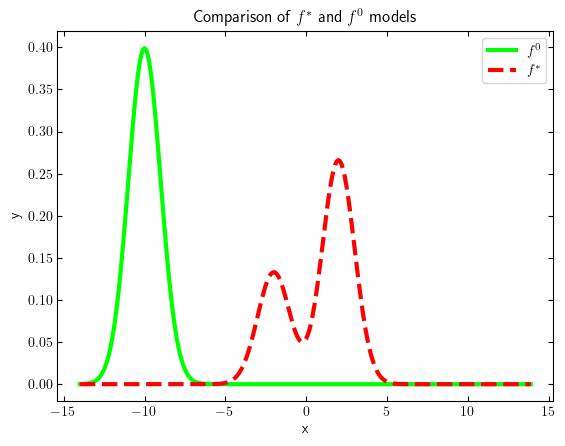

In [7]:
y = f_star(pixels)
y_0 = f_0(pixels)

plt.plot(pixels,y_0,color='lime',label=r'$f^0$', linewidth=3)
plt.plot(pixels,y,color='red',label=r'$f^*$', linestyle='dashed', linewidth=3)
plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.legend(loc='best', prop={'size': 10})
plt.title('Comparison of '+r'$f^*$'+' and '+r'$f^0$'+' models')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Training

In [8]:
'''
--------------------------------Adjust kernel
# The kernel we use.
def rbf_kernel(x_1, x_2):
    
    x_1: [13,15]
    x_2: [10,11,12,13,14,15]
    output: #row - #example
            #col - #list
        [[4.2484e-18, 3.3546e-04, 1.2664e-14],
        [2.0612e-09, 2.6103e-23, 2.9375e-30]]
    interleave: a,b,c -> a,a,b,b,c,c for cross norm
    reshape: split it to do block minus '-'
    h=2*med^2/ln(n)
    if pixel, x_2 has all same value then kernle norm is 1
    
    #print(torch.repeat_interleave(x_1,len(x_2),dim=0))
    big_x1 = torch.repeat_interleave(x_1,len(x_2),dim=0).reshape(len(x_1),len(x_2))#.cuda()
    #print(big_x1)
    #print(big_x1 - x_2)
    norm = (big_x1 - x_2)**2    #torch.norm ((big_x1 - x_2), dim=0)#.type(dtype)
    #print(norm)
    med_sq,_ = torch.median(norm,dim=1)
    rec_h=torch.unsqueeze(np.log(np.sqrt(len(x_2)))/(med_sq), 1)
    #print(rec_h)
    #print(med)
    return torch.exp(-torch.mul(norm,rec_h))#.cuda()
'''

"\n--------------------------------Adjust kernel\n# The kernel we use.\ndef rbf_kernel(x_1, x_2):\n    \n    x_1: [13,15]\n    x_2: [10,11,12,13,14,15]\n    output: #row - #example\n            #col - #list\n        [[4.2484e-18, 3.3546e-04, 1.2664e-14],\n        [2.0612e-09, 2.6103e-23, 2.9375e-30]]\n    interleave: a,b,c -> a,a,b,b,c,c for cross norm\n    reshape: split it to do block minus '-'\n    h=2*med^2/ln(n)\n    if pixel, x_2 has all same value then kernle norm is 1\n    \n    #print(torch.repeat_interleave(x_1,len(x_2),dim=0))\n    big_x1 = torch.repeat_interleave(x_1,len(x_2),dim=0).reshape(len(x_1),len(x_2))#.cuda()\n    #print(big_x1)\n    #print(big_x1 - x_2)\n    norm = (big_x1 - x_2)**2    #torch.norm ((big_x1 - x_2), dim=0)#.type(dtype)\n    #print(norm)\n    med_sq,_ = torch.median(norm,dim=1)\n    rec_h=torch.unsqueeze(np.log(np.sqrt(len(x_2)))/(med_sq), 1)\n    #print(rec_h)\n    #print(med)\n    return torch.exp(-torch.mul(norm,rec_h))#.cuda()\n"

$ K = e^{-\left(\frac{(x_1 - x_2)^2}{h}\right)}$

In [9]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    x_1: [1,2,3,...]
    '''
    return torch.exp(-(((x_1 - x_2) / 0.5) ** 2))

In [10]:
def greedy_B(y_t, y_s, batch):
    '''
    it can be threshold if batch <=1
    y_t, y_s are [x1,x2,x3]
    output: index of top k in x_list corresponded to y_t
    '''
    dif = torch.abs(y_t-y_s)
    
    #one point or many point
    if batch > 1 or  batch == 1:
        _, ind = torch.topk(dif,batch)
    elif (batch>0 and batch<1) or  batch == -1:
        _, ind = torch.topk(dif,int(torch.abs(batch)*len(y_s)))
    else:
        print("Invalid batch!")
    
    return ind

Square loss $L[f]=(y_i-f(x_i))^2$  $DL[f]=-2(y_i-f(x_i))K(x_i, \cdot)$

In [11]:
def gradient(x, y, x_list, y_t, K): #add a argument "type" for specified loss
    '''
    batch gradient, not argmin
    If there are multiple minimal values then the indices of the first minimal value are returned.
    
    f_0: N(-10,1)
    obj: torch.arange(-14, 14, 0.5)
    input x: [1,2,3] int pixel
    input y: [label1,label2]
    input x_list: [1,2,3]
    input y_t: [x1,x2,x3] corresponds to x_list
    output gradient: [x1,x2,x3] long, same order as x_list
    K: 
    '''
    
    '''
    Search the index of input x
    '''
    _, ind = torch.topk(torch.abs(x_list-x),1, largest=False)
    f_x=y_t[ind]#same long as x
    
    #square_loss
    '''
    unsqueeze for eache example mul each corresponded K
    '''
    gradient = -2*torch.unsqueeze((y-f_x), 1)*K(x, x_list)
    
    '''
    mean->1*len(x_list)
    '''
    gradient = torch.mean(gradient,axis=0)
    print('gradient: ',torch.norm(gradient))
    return gradient

In [45]:
clear_print
'''
Only change points corresponding to example provided
'''
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
selexp_t = []
y_0 = f_0(pixels)
f_t.append(y_0)
y_star = f_star(pixels)
loss_0 = np.linalg.norm(y_0-y_star)/len(y_star)
loss_t.append(loss_0)
tm_t.append(0)
#selexp_t.append(float('nan')) no need to add nan, the first selected is based on f^0

iter_count = 0
step = 0.05*num_iterations
while iter_count < num_iterations:
    if loss_t[-1]<0.0001:
        break
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)
    
    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    
    sel_idx = greedy_B(f_t[-1], y_star, 1)
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''
    
    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    example = pixels[sel_idx]#torch.tensor([14,14])
    label = f_star(example)
    selexp_t.append(float(example))
    
    '''
    torch.Size([784]) - torch.Size([784])
    '''
    f_t.append((f_t[-1] -eta*gradient(example, label, pixels, f_t[-1], rbf_kernel)))
    loss_t.append(np.linalg.norm(f_t[-1]-y_star)/len(y_star))
    tm_t.append(time.time() - training_start_time)
    iter_count += 1
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

NameError: name 'clear_print' is not defined

In [13]:
#data_path = os.path.join(script_path,'data','matching','cheetah.jpg')
save_path = os.path.join(script_path,'out','toy')

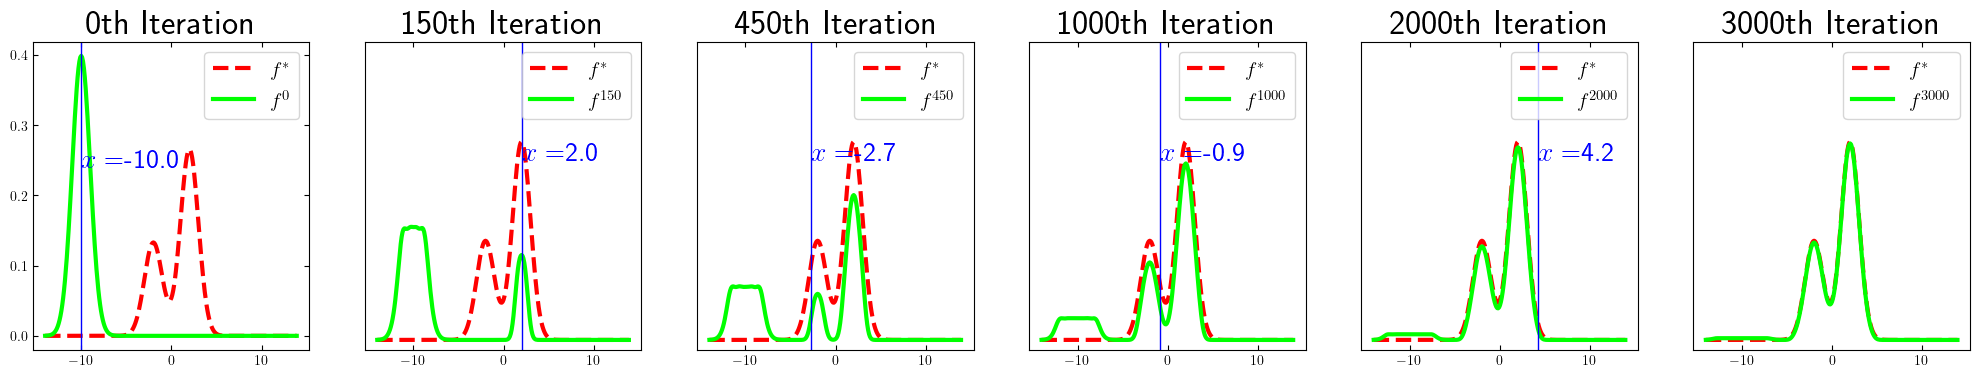

In [14]:
#plt.plot(pixels,y_0,color='lime',label=r'$f^0$', linewidth=3)
ite_list = [0, 150, 450, 1000, 2000, 3000]

sf = plt.figure(figsize=(25,4))

ind = 0

for i in ite_list:
    ind += 1
    
    plt.subplot(1,len(ite_list),ind)
    plt.plot(pixels,y,color='red',label=r'$f^*$', linestyle='dashed', linewidth=3)
    plt.plot(pixels,f_t[i],color='lime',label=r'$f^{{{}}}$'.format(i), linestyle='-', linewidth=3)
    if ind < len(ite_list):
        plt.axvline(x=selexp_t[i],ls="-",c="b", linewidth=1)
        plt.text(selexp_t[i],0.25,r'$x=${:.1f}'.format(selexp_t[i]),fontdict={'size':'20','color':'b'},horizontalalignment='left',verticalalignment='center')
    plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
    plt.legend(loc='upper right', prop={'size': 15})
    plt.title('{}th Iteration'.format(i),size = 25)
    plt.yticks(np.arange(0, 0.401, .1))
    if ind >1: 
        plt.yticks([]) 
    #plt.xlabel('x')
    #plt.ylabel('y')
plt.show()

sf.savefig(save_path+'/distribution.pdf',bbox_inches='tight')

### 2D Parametric model

$ y_i = 2x+1$

In [15]:
# Create toy dataset.
def f_star(x):
    y = x+1
    return y

$ y_i = \frac{1}{\sqrt(2\pi)}e^{-\frac{\left(x_i + 10\right)^2}{2}}$

In [16]:
# Create toy dataset.
def f_0(x):
    y = np.exp(-(((x - 0.5) / 0.5) ** 2)) + np.exp(-(((x + 0.5) / 0.5) ** 2))
    return y

In [17]:
# Obtain data.
pixels = torch.arange(-1, 1, 0.1)

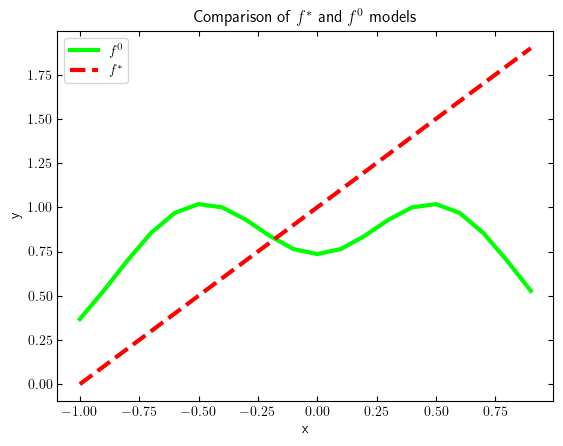

In [18]:
y = f_star(pixels)
y_0 = f_0(pixels)

plt.plot(pixels,y_0,color='lime',label=r'$f^0$', linewidth=3)
plt.plot(pixels,y,color='red',label=r'$f^*$', linestyle='dashed', linewidth=3)
plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.legend(loc='best', prop={'size': 10})
plt.title('Comparison of '+r'$f^*$'+' and '+r'$f^0$'+' models')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Training

$ K = e^{-\left(\frac{(x_1 - x_2)^2}{h}\right)}$

In [19]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    x_1: [1,2,3,...]
    '''
    return torch.exp(-(((x_1 - x_2) / 0.5) ** 2))

In [20]:
def greedy_B(y_t, y_s, batch):
    '''
    it can be threshold if batch <=1
    y_t, y_s are [x1,x2,x3]
    output: index of top k in x_list corresponded to y_t
    '''
    dif = torch.abs(y_t-y_s)
    
    #one point or many point
    if batch > 1 or  batch == 1:
        _, ind = torch.topk(dif,batch)
    elif (batch>0 and batch<1) or  batch == -1:
        _, ind = torch.topk(dif,int(torch.abs(batch)*len(y_s)))
    else:
        print("Invalid batch!")
    
    return ind

Square loss $L[f]=(y_i-f(x_i))^2$  $DL[f]=-2(y_i-f(x_i))K(x_i, \cdot)$

In [21]:
def gradient(x, y, x_list, y_t, K): #add a argument "type" for specified loss
    '''
    batch gradient, not argmin
    If there are multiple minimal values then the indices of the first minimal value are returned.
    
    f_0: N(-10,1)
    obj: torch.arange(-14, 14, 0.5)
    input x: [1,2,3] int pixel
    input y: [label1,label2]
    input x_list: [1,2,3]
    input y_t: [x1,x2,x3] corresponds to x_list
    output gradient: [x1,x2,x3] long, same order as x_list
    K: 
    '''
    
    '''
    Search the index of input x
    '''
    _, ind = torch.topk(torch.abs(x_list-x),1, largest=False)
    f_x=y_t[ind]#same long as x
    
    #square_loss
    '''
    unsqueeze for eache example mul each corresponded K
    '''
    gradient = -2*torch.unsqueeze((y-f_x), 1)*K(x, x_list)
    
    '''
    mean->1*len(x_list)
    '''
    gradient = torch.mean(gradient,axis=0)
    print('gradient: ',torch.norm(gradient))
    return gradient

In [46]:
clear_print
'''
Only change points corresponding to example provided
'''
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
selexp_t = []
y_0 = f_0(pixels)
f_t.append(y_0)
y_star = f_star(pixels)
loss_0 = np.linalg.norm(y_0-y_star)/len(y_star)
loss_t.append(loss_0)
tm_t.append(0)
#selexp_t.append(float('nan')) no need to add nan, the first selected is based on f^0

iter_count = 0
step = 0.05*num_iterations
while iter_count < num_iterations:
    if loss_t[-1]<0.0001:
        break
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)
    
    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    
    sel_idx = greedy_B(f_t[-1], y_star, 1)
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''
    
    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    example = pixels[sel_idx]#torch.tensor([14,14])
    label = f_star(example)
    selexp_t.append(float(example))
    
    '''
    torch.Size([784]) - torch.Size([784])
    '''
    f_t.append((f_t[-1] -eta*gradient(example, label, pixels, f_t[-1], rbf_kernel)))
    loss_t.append(np.linalg.norm(f_t[-1]-y_star)/len(y_star))
    tm_t.append(time.time() - training_start_time)
    iter_count += 1
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

NameError: name 'clear_print' is not defined

In [23]:
#data_path = os.path.join(script_path,'data','matching','cheetah.jpg')
save_path = os.path.join(script_path,'out','toy')

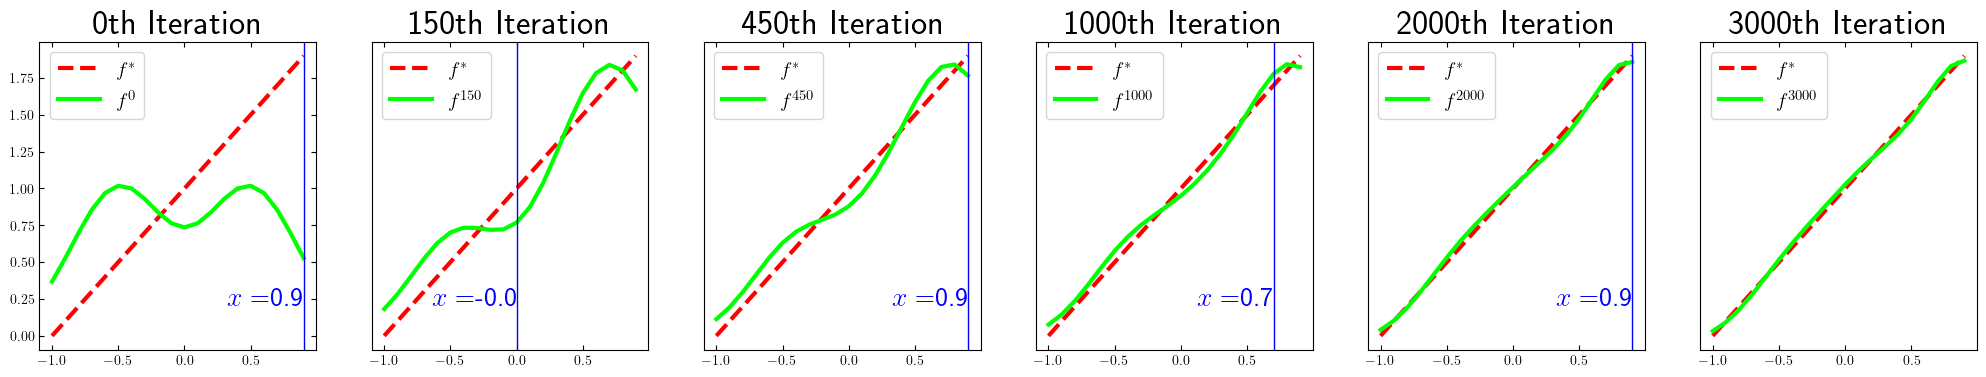

In [24]:
#plt.plot(pixels,y_0,color='lime',label=r'$f^0$', linewidth=3)
#------------------------y = x+1
ite_list = [0, 150, 450, 1000, 2000, 3000]

sf = plt.figure(figsize=(25,4))

ind = 0

for i in ite_list:
    ind += 1
    
    plt.subplot(1,len(ite_list),ind)
    plt.plot(pixels,y_star,color='red',label=r'$f^*$', linestyle='dashed', linewidth=3)
    plt.plot(pixels,f_t[i],color='lime',label=r'$f^{{{}}}$'.format(i), linestyle='-', linewidth=3)
    if ind < len(ite_list):
        plt.axvline(x=selexp_t[i],ls="-",c="b", linewidth=1)
        plt.text(selexp_t[i],0.25,r'$x=${:.1f}'.format(selexp_t[i]),fontdict={'size':'20','color':'b'},horizontalalignment='right',verticalalignment='center')
    plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
    plt.legend(loc='upper left', prop={'size': 15})
    plt.title('{}th Iteration'.format(i),size = 25)
    #plt.yticks(np.arange(0, 0.401, .1))
    if ind >1: 
        plt.yticks([]) 
    #plt.xlabel('x')
    #plt.ylabel('y')
plt.show()

sf.savefig(save_path+'/parametric1.pdf',bbox_inches='tight')

#### Just need to retrain

In [25]:
# Create toy dataset. case 2
def f_star(x):
    y = -x+1
    return y

In [47]:
clear_print
'''
Only change points corresponding to example provided
'''
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
selexp_t = []
y_0 = f_0(pixels)
f_t.append(y_0)
y_star = f_star(pixels)
loss_0 = np.linalg.norm(y_0-y_star)/len(y_star)
loss_t.append(loss_0)
tm_t.append(0)
#selexp_t.append(float('nan')) no need to add nan, the first selected is based on f^0

iter_count = 0
step = 0.05*num_iterations
while iter_count < num_iterations:
    if loss_t[-1]<0.0001:
        break
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)
    
    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    
    sel_idx = greedy_B(f_t[-1], y_star, 1)
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''
    
    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    example = pixels[sel_idx]#torch.tensor([14,14])
    label = f_star(example)
    selexp_t.append(float(example))
    
    '''
    torch.Size([784]) - torch.Size([784])
    '''
    f_t.append((f_t[-1] -eta*gradient(example, label, pixels, f_t[-1], rbf_kernel)))
    loss_t.append(np.linalg.norm(f_t[-1]-y_star)/len(y_star))
    tm_t.append(time.time() - training_start_time)
    iter_count += 1
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

NameError: name 'clear_print' is not defined

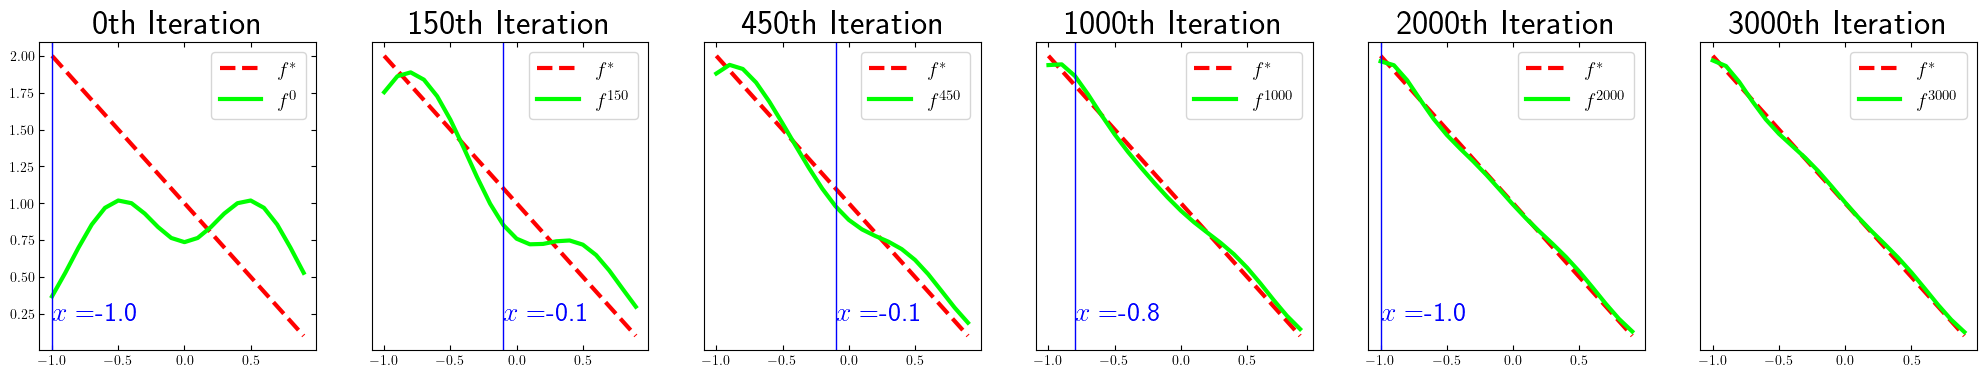

In [27]:
#plt.plot(pixels,y_0,color='lime',label=r'$f^0$', linewidth=3)
#------------------------y = -x+1
ite_list = [0, 150, 450, 1000, 2000, 3000]

sf = plt.figure(figsize=(25,4))

ind = 0

for i in ite_list:
    ind += 1
    
    plt.subplot(1,len(ite_list),ind)
    plt.plot(pixels,y_star,color='red',label=r'$f^*$', linestyle='dashed', linewidth=3)
    plt.plot(pixels,f_t[i],color='lime',label=r'$f^{{{}}}$'.format(i), linestyle='-', linewidth=3)
    if ind < len(ite_list):
        plt.axvline(x=selexp_t[i],ls="-",c="b", linewidth=1)
        plt.text(selexp_t[i],0.25,r'$x=${:.1f}'.format(selexp_t[i]),fontdict={'size':'20','color':'b'},horizontalalignment='left',verticalalignment='center')
    plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
    plt.legend(loc='upper right', prop={'size': 15})
    plt.title('{}th Iteration'.format(i),size = 25)
    #plt.yticks(np.arange(0, 0.401, .1))
    if ind >1: 
        plt.yticks([]) 
    #plt.xlabel('x')
    #plt.ylabel('y')
plt.show()

sf.savefig(save_path+'/parametric2.pdf',bbox_inches='tight')

### 2D Parametric VS nonparametric

In [28]:
import torch
import time
eta = 0.01  # Learning rate.
num_iterations = 1000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

##### With intercept

In [29]:
# Create toy dataset.
def f_star(x):
    y = x+1
    return y

In [30]:
# Create toy dataset.
def f_0(x):
    y = -0.5*x+0.5
    return y

In [31]:
theta_0 = torch.tensor([-0.5,0.5])

##### Without intercept

In [32]:
# Create toy dataset.
def f_star(x):
    y = x
    return y

In [33]:
# Create toy dataset.
def f_0(x):
    y = -0.5*x
    return y

In [34]:
theta_0 = torch.tensor([-0.5,0])

In [35]:
# Obtain data.
pixels = torch.arange(-1, 1, 0.1)

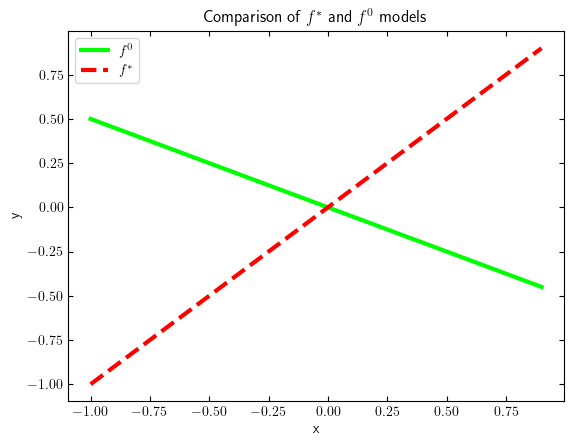

In [36]:
y = f_star(pixels)
y_0 = f_0(pixels)

plt.plot(pixels,y_0,color='lime',label=r'$f^0$', linewidth=3)
plt.plot(pixels,y,color='red',label=r'$f^*$', linestyle='dashed', linewidth=3)
plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.legend(loc='best', prop={'size': 10})
plt.title('Comparison of '+r'$f^*$'+' and '+r'$f^0$'+' models')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Training

$ K = e^{-\left(\frac{(x_1 - x_2)^2}{h}\right)}$

In [37]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    x_1: [1,2,3,...]
    '''
    return torch.exp(-(((x_1 - x_2) / 0.5) ** 2))

In [38]:
# The kernel we use.
def lin_kernel(x_1, x_2):
    '''
    x_1: [1,2,3,...]
    '''
    return torch.mul(x_1, x_2)+1

In [39]:
# The kernel we use for cases without intercept.
def lin_kernel_noB(x_1, x_2):
    '''
    x_1: [1,2,3,...]
    '''      
    return torch.mul(x_1, x_2)

In [40]:
def greedy_B(y_t, y_s, batch):
    '''
    it can be threshold if batch <=1
    y_t, y_s are [x1,x2,x3]
    output: index of top k in x_list corresponded to y_t
    '''
    dif = torch.abs(y_t-y_s)
    
    #one point or many point
    if batch > 1 or  batch == 1:
        _, ind = torch.topk(dif,batch)
    elif (batch>0 and batch<1) or  batch == -1:
        _, ind = torch.topk(dif,int(torch.abs(batch)*len(y_s)))
    else:
        print("Invalid batch!")
    
    return ind

Square loss $L[f]=(y_i-f(x_i))^2$  $DL[f]=-2(y_i-f(x_i))K(x_i, \cdot)$

In [41]:
def gradient(x, y, x_list, y_t, K): #add a argument "type" for specified loss
    '''
    batch gradient, not argmin
    If there are multiple minimal values then the indices of the first minimal value are returned.
    
    f_0: N(-10,1)
    obj: torch.arange(-14, 14, 0.5)
    input x: [1,2,3] int pixel
    input y: [label1,label2]
    input x_list: [1,2,3]
    input y_t: [x1,x2,x3] corresponds to x_list
    output gradient: [x1,x2,x3] long, same order as x_list
    K: 
    '''
    
    '''
    Search the index of input x
    '''
    _, ind = torch.topk(torch.abs(x_list-x),1, largest=False)
    f_x=y_t[ind]#same long as x
    
    #square_loss
    '''
    unsqueeze for eache example mul each corresponded K
    '''
    gradient = -2*torch.unsqueeze((y-f_x), 1)*K(x, x_list)
    
    '''
    mean->1*len(x_list)
    '''
    gradient = torch.mean(gradient,axis=0)
    print('gradient: ',torch.norm(gradient))
    return gradient

In [42]:
def gradient_para(x, y, theta_t, intercept = True): #add a argument "type" for specified loss
    '''
    One input x not batch
    Both homogeneous and nonhomogeneous
    
    f_0: N(-10,1)
    obj: torch.arange(-14, 14, 0.5)
    input x: [1.1,2,3.2]
    input y: [label1,label2]
    input theta_t: [x1,x2] is a vector
    output gradient: [x1,x2] long, akin to theta_t
    '''
    
    '''
    Since theta has b but input has not.
    add one dimension and set its value as one for matrix mul
    '''
    if intercept:
        if len(x) < len(theta_t):
            x=torch.hstack((x,torch.ones(1)))

        f_x = torch.matmul(x,theta_t)
        #square_loss

        gradient = -2*(y-f_x)*x
        
    #last item in theta_t should be 0
    else:
        if len(x) < len(theta_t):
            x=torch.hstack((x,torch.zeros(1)))

        f_x = torch.matmul(x,theta_t)
        #square_loss

        gradient = -2*(y-f_x)*x        
    
    print('gradient: ',torch.norm(gradient))
    return gradient

In [48]:
clear_print
'''
Only change points corresponding to example provided
'''
training_start_time = time.time()
#records
f_t = []
f_t_lin = []
theta_t = []
loss_t = []
tm_t = []
selexp_t = []
y_0 = f_0(pixels)
f_t.append(y_0)
f_t_lin.append(y_0)
theta_t.append(theta_0)
y_star = f_star(pixels)
loss_0 = np.linalg.norm(y_0-y_star)/len(y_star)
loss_t.append(loss_0)
tm_t.append(0)
#selexp_t.append(float('nan')) no need to add nan, the first selected is based on f^0

iter_count = 0
step = 0.05*num_iterations
while iter_count < num_iterations:
    
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)
    
    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    
    sel_idx = greedy_B(f_t[-1], y_star, 1)# based on results of RBF kernel
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),1)#int(0.05*len(y_star))
    '''
    
    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    example = pixels[sel_idx]#torch.tensor([14,14])
    label = f_star(example)
    selexp_t.append(float(example))
    
    '''
    torch.Size([784]) - torch.Size([784])
    '''
    f_t.append(f_t[-1] -eta*gradient(example, label, pixels, f_t[-1], rbf_kernel))
    f_t_lin.append(f_t_lin[-1] -eta*gradient(example, label, pixels, f_t_lin[-1], lin_kernel)) #lin_kernel_noB
    theta_t.append(theta_t[-1] -eta*gradient_para(example, label, theta_t[-1])) #, intercept=False
    loss_t.append(np.linalg.norm(f_t[-1]-y_star)/len(y_star))
    tm_t.append(time.time() - training_start_time)
    iter_count += 1
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

NameError: name 'clear_print' is not defined

In [44]:
#data_path = os.path.join(script_path,'data','matching','cheetah.jpg')
save_path = os.path.join(script_path,'out','toy')

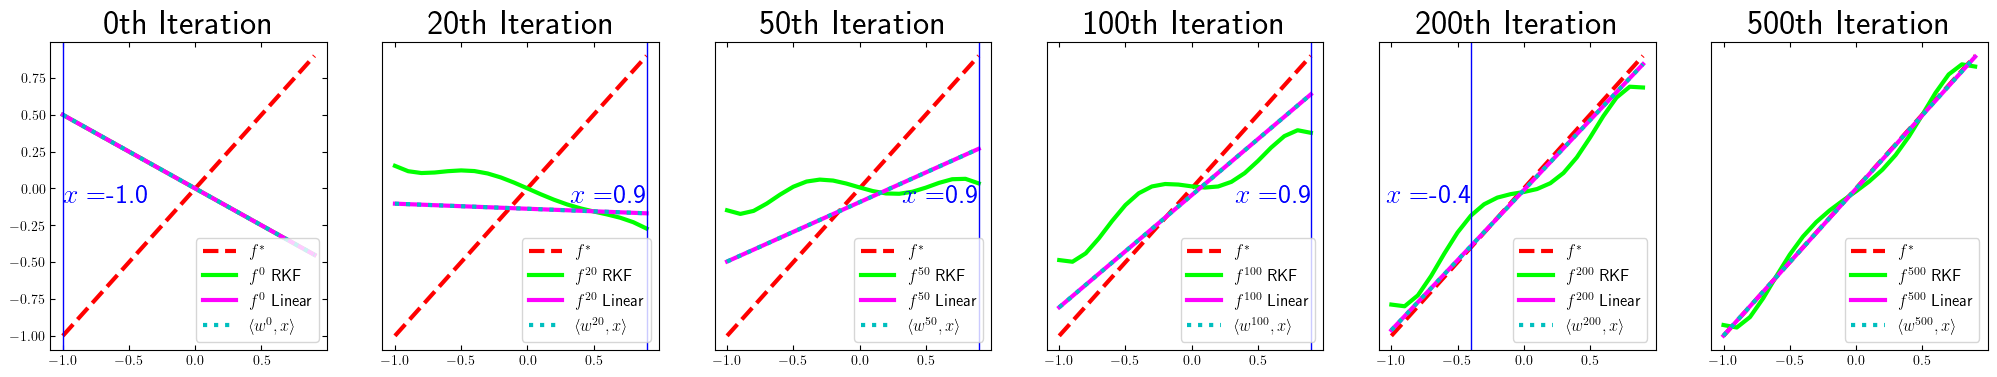

In [50]:
#plt.plot(pixels,y_0,color='lime',label=r'$f^0$', linewidth=3)
#------------------------y = x+1
ite_list = [0, 20, 50, 100, 200, 500]

sf = plt.figure(figsize=(25,4))

ind = 0

for i in ite_list:
    ind += 1
    
    plt.subplot(1,len(ite_list),ind)
    plt.plot(pixels,y_star,color='red',label=r'$f^*$', linestyle='dashed', linewidth=3)
    plt.plot(pixels,f_t[i],color='lime',label=r'$f^{{{}}}$ RKF'.format(i), linestyle='-', linewidth=3)
    plt.plot(pixels,f_t_lin[i],color='magenta',label=r'$f^{{{}}}$ Linear'.format(i), linestyle='-', linewidth=3)
    def f_t_plt(X):
        '''
        change here
        '''
        Y = theta_t[i][0]*X+ theta_t[i][1]
        return Y
    plt.plot(pixels,f_t_plt(pixels),color='c',label=r'$\langle w^{{{}}}$'.format(i)+r'$,x \rangle$', linestyle=':', linewidth=3)
    
    if ind==1:
        plt.axvline(x=selexp_t[i],ls="-",c="b", linewidth=1)
        plt.text(selexp_t[i],-0.05,r'$x=${:.1f}'.format(selexp_t[i]),fontdict={'size':'20','color':'b'},horizontalalignment='left',verticalalignment='center')
    if ind < len(ite_list) and ind>1:
        plt.axvline(x=selexp_t[i],ls="-",c="b", linewidth=1)
        plt.text(selexp_t[i],-0.05,r'$x=${:.1f}'.format(selexp_t[i]),fontdict={'size':'20','color':'b'},horizontalalignment='right',verticalalignment='center')
    plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
    plt.legend(loc='lower right', prop={'size': 12})
    plt.title('{}th Iteration'.format(i),size = 25)
    #plt.yticks(np.arange(0, 0.401, .1))
    if ind >1: 
        plt.yticks([]) 
    #plt.xlabel('x')
    #plt.ylabel('y')
plt.show()

sf.savefig(save_path+'/linearK.pdf',bbox_inches='tight')

### 3D parametric

In [51]:
import time
eta = 0.01  # Learning rate.
num_iterations = 10000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

# Obtain pixels.
x1 = torch.arange(0, 10, 1)
x2 = torch.arange(0, 10, 1)
x1, x2 = torch.meshgrid(x1, x2)
pixels = torch.vstack((x1.flatten(),x2.flatten())).T.cuda()

D:\Anaconda\envs\mytorch\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [52]:
print('GPU: ',torch.cuda.is_available())
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

GPU:  True


In [53]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Square loss $L[f]=(y_i-f(x_i))^2$  $DL[f]=-2(y_i-f(x_i))K(x_i, \cdot)$

In [54]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    x_1: [[13,15],[12,17]]
    x_2: [[10,16],[14,14],[11,13]]
    output: #row - #example
            #col - #list
        [[4.2484e-18, 3.3546e-04, 1.2664e-14],
        [2.0612e-09, 2.6103e-23, 2.9375e-30]]
    interleave: a,b,c -> a,a,b,b,c,c for cross norm
    reshape: split it to do block minus '-'
    '''
    big_x1 = torch.repeat_interleave(x_1,len(x_2),dim=0).reshape(len(x_1),len(x_2),2).cuda()
    #print(big_x1)
    #print(big_x1 - x_2)
    norm = torch.norm ((big_x1 - x_2).type(dtype), dim=2)
    #print(norm)
    return torch.exp(-(((norm) / 0.5) ** 2)).cuda()

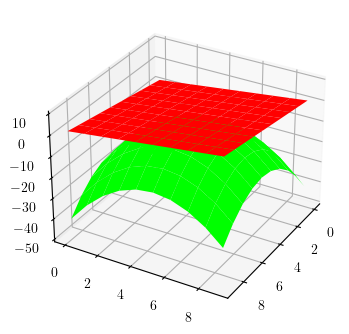

In [55]:
import matplotlib.pyplot as plt
import random
import matplotlib as mpl

def fun_opt(x, y):
    return x + y - 8

def fun_0(x, y):
    return -( (x-5)**2 + (y-5)**2)


fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, 10, 1)
X, Y = np.meshgrid(x, y)
zs = np.array(fun_opt(np.ravel(X), np.ravel(Y)))
Z_opt = zs.reshape(X.shape)
ax.plot_surface(X, Y, Z_opt, label="opt", color='red',shade=0,linewidth=0)

zs = np.array(fun_0(np.ravel(X), np.ravel(Y)))
Z_0 = zs.reshape(X.shape)
ax.plot_surface(X, Y, Z_0,label='initial', color='lime',shade=0,linewidth=0)

ax.view_init(30,30)

plt.show()

In [56]:
def f_0(example):
    '''
    f_0: '8'
    obj: 28*28 initial figure random
    example: [[x,y],[x,y]]
    output: [label1,label2]
    '''
    obj = torch.tensor(np.squeeze(Z_0, axis=None),dtype=torch.float64, device=None)
    
    #one point or many point
    if len(example.shape) > 1:
        x, y = example[:,0], example[:,1]
    else:
        x, y = example[0], example[1]

    Z = obj[x,y] # here we need to change the type to ap.array
    return Z.cuda()

In [57]:
def f_star(example):
    '''
    f_star: '0'
    obj: 28*28 should be the best profile
    example: [[x,y],[x,y]]
    '''
    obj = torch.tensor(np.squeeze(Z_opt, axis=None),dtype=torch.float64, device=None)
    
    #one point or many point
    if len(example.shape) > 1:
        x, y = example[:,0], example[:,1]
    else:
        x, y = example[0], example[1]
    
    Z = obj[x,y] # here we need to change the type to ap.array
    return Z.cuda()

In [58]:
def greedy_B(y_t, y_s, batch, pool=False, plScale= 0.5):
    '''
    it can be threshold if batch <=1
    y_t, y_s are [x1,x2,x3]
    output: index of top k in x_list corresponded to y_t
    '''
    dif = torch.abs(y_t-y_s)
    if pool:
        '''
        Keep original order
        '''
        np.random.seed(seed)
        k=np.random.choice(len(y_s), int(plScale*len(y_s)), replace=False) #without replacement
        #print(k[0:5])
        tem_dif = torch.zeros_like(dif)
        tem_dif[k] = dif[k]
        dif = tem_dif
    
    #one point or many point
    if batch > 1 or  batch == 1:
        _, ind = torch.topk(dif,batch)
    elif (batch>0 and batch<1) or  batch == -1:
          _, ind = torch.topk(dif,int(np.abs(batch)*len(dif)))
    else:
        print("Invalid batch!")
    
    return ind

In [59]:
def gradient(x, y, x_list, y_t, K): #add a argument "type" for specified loss
    '''
    batch gradient, not argmin
    If there are multiple minimal values then the indices of the first minimal value are returned.
    
    f_0: '8'
    obj: 28*28
    input x: [[x1,x2],[x1,x2]] int pixel point
    input y: [label1,label2]
    input x_list: [[x1,x2],[x1,x2],[x1,x2]]
    input y_t: [x1,x2,x3] corresponds to x_list
    output gradient: [x1,x2,x3] long, same order as x_list
    K: K(2*2,dim=3*2) output 2*3 2:two input centor, 3:three compute list(pixel)
    '''
    if len(x.shape) == 1:
        x = torch.unsqueeze(x, 0)
    # according to the rule of pixel layout and assume figure are square
    wid = np.sqrt(len(x_list))
    w = torch.tensor([wid,1], dtype=torch.float64).cuda()
    #print(w.dtype,x.dtype)
    ind = torch.matmul(x.type(torch.float64),w) #+1  no need to add 1 since the first one is indexed at 0
    ind = ind.type(torch.int64)
    f_x=y_t[ind]#same long as x
    
    #square_loss
    #print(torch.unsqueeze((y-f_x), 1))
    '''
    unsqueeze for eache example mul each corresponded K
    '''
    gradient = -2*torch.unsqueeze((y-f_x), 1)*K(x, x_list)
    
    '''
    mean->1*len(x_list)
    '''
    gradient = torch.mean(gradient,axis=0)
    print('gradient: ',torch.norm(gradient))
    return gradient.cuda()

### Training

In [70]:
clear_print
'''
Only change points corresponding to example provided
'''
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
y_0 = f_0(pixels)
f_t.append(y_0)
y_star = f_star(pixels)
loss_0 = torch.norm(y_0-y_star)/len(y_star)
loss_t.append(loss_0.cpu())
tm_t.append(0)

iter_count = 0
step = 0.05*num_iterations
while iter_count < num_iterations:
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)
    
    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    
    sel_idx = greedy_B(f_t[-1], y_star, 1)#, pool=True, plScale= 0.8
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''
    
    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    example = pixels[sel_idx]#torch.tensor([14,14])
    print(example)
    '''
    intorduce replacement
    '''
    label = f_star(example)
    
    '''
    torch.Size([784]) - torch.Size([784])
    '''
    f_t.append((f_t[-1] -eta*gradient(example, label, pixels, f_t[-1], rbf_kernel)))
    loss_t.append((torch.norm(f_t[-1]-y_star)/len(y_star)).cpu())
    tm_t.append(time.time() - training_start_time)
    iter_count += 1
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

NameError: name 'clear_print' is not defined

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

from matplotlib.text import Annotation

class Annotation3D(Annotation):

    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)
        
def _annotate3D(ax, text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D, 'annotate3D', _annotate3D)

import numpy as np
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs) 
    
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

In [62]:
#data_path = os.path.join(script_path,'data','matching','cheetah.jpg')
save_path = os.path.join(script_path,'out','toy')

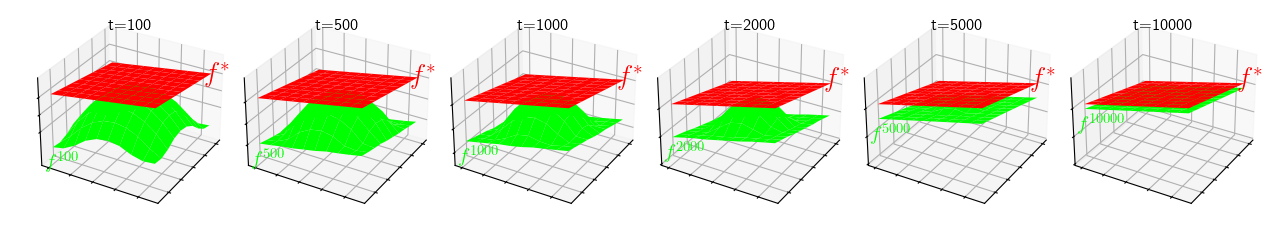

In [67]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

#from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(16,4))

# Make data. Draw 0
X = np.arange(0, 10, 1)
Y = np.arange(0, 10, 1)
X, Y = np.meshgrid(X, Y)

xticks = np.arange(0, 10, 2)
yticks = np.arange(0, 10, 2)
zticks = np.arange(-20, 10, 10)
empty_labels_x = ["" for i in range(len(xticks))]
empty_labels_y = ["" for i in range(len(yticks))]
empty_labels_z = ["" for i in range(len(zticks))]


ite_list = [100, 500, 1000, 2000, 5000, 10000]#[5000, 10000,20000, 40000]##[10000, 20000,40000, 60000]#[1000, 5000, 10000,20000]
for i in ite_list:
    j = ite_list.index(i)

    Z = f_t[i].cpu().numpy().reshape(10,10)#np.array(f_t_plt(X, Y)) # here we need to change the type to ap.array

    # Plot the surface.
    ax = fig.add_subplot(1, len(ite_list), j+1, projection='3d')
    
    surf = ax.plot_surface(X, Y, Z, color='lime',shade=0,linewidth=0)
    ax.plot_surface(X, Y, Z_opt, label="opt", color='red',shade=0,linewidth=0)

    # Customize the z axis.
    #ax.set_zlim(-1.01, 1.01)
    #ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    #ax.zaxis.set_major_formatter('{x:.02f}')
    
    '''ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_axis_off()'''
    ax.set_xticks(xticks, empty_labels_x)
    ax.set_yticks(yticks, empty_labels_y)
    ax.set_zticks(zticks, empty_labels_z)
    
    def f_t_plt(X,Y):
        '''
        change here
        '''
        obj = f_t[i].cpu().numpy().reshape(10,10)
        Z = obj[X,Y] # here we need to change the type to ap.array
        return Z
    
    ax.annotate3D(r'$f^*$', (0,9,6), xytext=(-5, -12), textcoords='offset points', color='red',size=20)
    ax.annotate3D(r'$f^{{{}}}$'.format(i), (9,0,f_t_plt(9,0)), xytext=(-5, -15), textcoords='offset points', color='lime',size=15)
    

    ax.view_init(30,30)
    plt.title('t={}'.format(i),y=1, loc='center',horizontalalignment='center', verticalalignment='top')
tight_coe = 0
fig.subplots_adjust(wspace=tight_coe, hspace=tight_coe)
plt.show()
fig.savefig(save_path+'/parametric3.pdf',bbox_inches='tight')

#### Just need to retrain

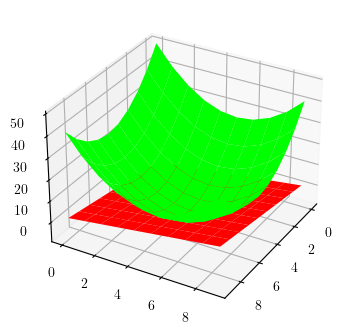

In [68]:
import matplotlib.pyplot as plt
import random
import matplotlib as mpl

def fun_opt(x, y):
    return x + y - 8

def fun_0(x, y):
    return (x-5)**2 + (y-5)**2


fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(0, 10, 1)
X, Y = np.meshgrid(x, y)
zs = np.array(fun_opt(np.ravel(X), np.ravel(Y)))
Z_opt = zs.reshape(X.shape)
ax.plot_surface(X, Y, Z_opt, label="opt", color='red',shade=0,linewidth=0)

zs = np.array(fun_0(np.ravel(X), np.ravel(Y)))
Z_0 = zs.reshape(X.shape)
ax.plot_surface(X, Y, Z_0,label='initial', color='lime',shade=0,linewidth=0)

ax.view_init(30,30)

plt.show()

In [72]:
clear_print
'''
Only change points corresponding to example provided
'''
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
y_0 = f_0(pixels)
f_t.append(y_0)
y_star = f_star(pixels)
loss_0 = torch.norm(y_0-y_star)/len(y_star)
loss_t.append(loss_0.cpu())
tm_t.append(0)

iter_count = 0
step = 0.05*num_iterations
while iter_count < num_iterations:
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)
    
    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    
    sel_idx = greedy_B(f_t[-1], y_star, 1)#, pool=True, plScale= 0.8
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''
    
    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    example = pixels[sel_idx]#torch.tensor([14,14])
    print(example)
    '''
    intorduce replacement
    '''
    label = f_star(example)
    
    '''
    torch.Size([784]) - torch.Size([784])
    '''
    f_t.append((f_t[-1] -eta*gradient(example, label, pixels, f_t[-1], rbf_kernel)))
    loss_t.append((torch.norm(f_t[-1]-y_star)/len(y_star)).cpu())
    tm_t.append(time.time() - training_start_time)
    iter_count += 1
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

NameError: name 'clear_print' is not defined

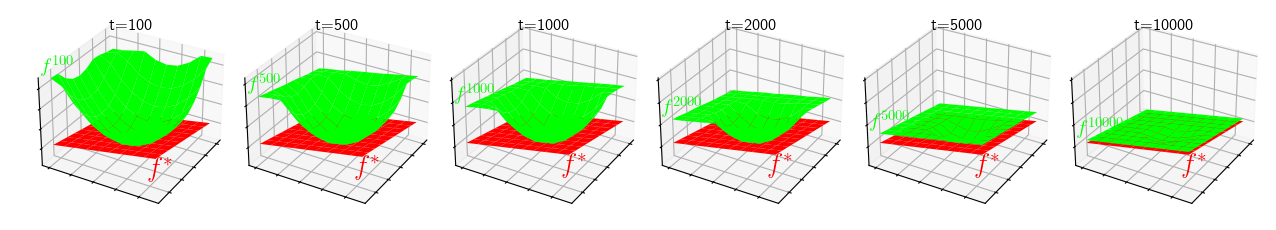

In [71]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

#from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(16,4))

# Make data. Draw 0
X = np.arange(0, 10, 1)
Y = np.arange(0, 10, 1)
X, Y = np.meshgrid(X, Y)

xticks = np.arange(0, 10, 2)
yticks = np.arange(0, 10, 2)
zticks = np.arange(0, 40, 10)
empty_labels_x = ["" for i in range(len(xticks))]
empty_labels_y = ["" for i in range(len(yticks))]
empty_labels_z = ["" for i in range(len(zticks))]


ite_list = [100, 500, 1000, 2000, 5000, 10000]#[5000, 10000,20000, 40000]##[10000, 20000,40000, 60000]#[1000, 5000, 10000,20000]
for i in ite_list:
    j = ite_list.index(i)

    Z = f_t[i].cpu().numpy().reshape(10,10) # here we need to change the type to ap.array

    # Plot the surface.
    ax = fig.add_subplot(1, len(ite_list), j+1, projection='3d')
    
    surf = ax.plot_surface(X, Y, Z, color='lime',shade=0,linewidth=0)
    ax.plot_surface(X, Y, Z_opt, label="opt", color='red',shade=0,linewidth=0)

    # Customize the z axis.
    #ax.set_zlim(-1.01, 1.01)
    #ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    #ax.zaxis.set_major_formatter('{x:.02f}')
    
    '''ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_axis_off()'''
    ax.set_xticks(xticks, empty_labels_x)
    ax.set_yticks(yticks, empty_labels_y)
    ax.set_zticks(zticks, empty_labels_z)

    def f_t_plt(X,Y):
        '''
        change here
        '''
        obj = f_t[i].cpu().numpy().reshape(10,10)
        Z = obj[X,Y] # here we need to change the type to ap.array
        return Z
    
    ax.annotate3D(r'$f^*$', (9,9,7), xytext=(-5, -8), textcoords='offset points', color='red',size=20)
    ax.annotate3D(r'$f^{{{}}}$'.format(i), (9,0,f_t_plt(9,0)), xytext=(-7, 5), textcoords='offset points', color='lime',size=15)
    

    ax.view_init(30,30)
    plt.title('t={}'.format(i),y=1, loc='center',horizontalalignment='center', verticalalignment='top')
tight_coe = 0
fig.subplots_adjust(wspace=tight_coe, hspace=tight_coe)
plt.show()
fig.savefig(save_path+'/parametric4.pdf',bbox_inches='tight')

### General function not greedy

$ y_i = e^{-\left(\frac{x_i - 0.5}{0.5}\right)^2} + e^{-\left(\frac{x_i + 0.5}{0.5}\right)^2}$

In [ ]:
# Create toy dataset.
def f_star(x):
    y = np.exp(-(((x - 0.5) / 0.5) ** 2)) + np.exp(-(((x + 0.5) / 0.5) ** 2))
    return y

$ y_i = e^{-\left(\frac{x_i - 0.5}{0.5}\right)^2+0.5} + e^{-\left(\frac{x_i + 0.5}{0.5}\right)^2}$

In [ ]:
# Create toy dataset.
def f_0(x):
    y = np.exp(-(((x - 0.5) / 0.5) ** 2)+0.5) + np.exp(-(((x + 0.5) / 0.5) ** 2)-0.5)
    return y

In [ ]:
# Obtain data.
x = np.linspace(-1, 1, 50)

y = f_star(x)
y_0 = f_0(x)

plt.plot(x,y_0,color='lime',label=r'$f^0$')
plt.plot(x,y,color='red',label=r'$f^*$')
plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.legend(loc='best', prop={'size': 10})
plt.title('Comparison of '+r'$\theta^*$'+' and '+r'$\theta^0$'+' models')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Training

Square loss $L[f]=(y_i-f(x_i))^2$  $DL[f]=-2(y_i-f(x_i))K(x_i, \cdot)$

In [ ]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    return np.exp(-(((x_1 - x_2) / 0.5) ** 2))

In [ ]:
#batch gradient
def gradient(x, y, x_list, y_t, K): #add a argument "type" for specified loss
    '''
    input x: [x1, x2, ...], need np.newaxis -> [[x1],[x2]]
    '''
    #1D linear approximate
    cen = x_list[0:-1]+x_list[1:]/2
    #input data x should be [x1,x2,...,xn]
    dif=abs(x[:,np.newaxis]-cen)
    #lower ind
    ind = dif.argmin(axis=1)[:,np.newaxis]
    #ind
    ind = np.hstack((ind,ind+1))
    
    a, b = x_list[ind][:,0], x_list[ind][:,1]
    
    coe=(x-b)/(a-b)
    
    y_a=y_t[ind[:,0]]
    y_b=y_t[ind[:,1]]
    #print(coe)
    f_x=coe*y_a+(1-coe)*y_b#f_t(x) is a vector related to input x
    
    #square_loss
    gradient = -2*(y-f_x)[:,np.newaxis]*K(x[:,np.newaxis], x_list)
    
    gradient = gradient.mean(axis=0)
    #print(gradient)
    return gradient

Fixed example

In [ ]:
example_p_5 = np.array([0.5])
label_p_5 = f_star(example_p_5)
f_t_p_5 = []
f_t_p_5.append(y_0)

example_n_5 = np.array([-0.5])
label_n_5 = f_star(example_n_5)
f_t_n_5 = []
f_t_n_5.append(y_0)

example__0 = np.array([0])
label__0 = f_star(example__0)
f_t__0 = []
f_t__0.append(y_0)

example_np_5 = np.array([-0.5,0.5])
label_np_5 = f_star(example_np_5)
f_t_np_5 = []
f_t_np_5.append(y_0)

iter_count = 0

while iter_count < num_iterations:
    iter_count += 1
    f_t_p_5.append(f_t_p_5[-1] -eta*gradient(example_p_5, label_p_5, x, f_t_p_5[-1], rbf_kernel))
    f_t_n_5.append(f_t_n_5[-1] -eta*gradient(example_n_5, label_n_5, x, f_t_n_5[-1], rbf_kernel))
    f_t__0.append(f_t__0[-1] -eta*gradient(example__0, label__0, x, f_t__0[-1], rbf_kernel))
    f_t_np_5.append(f_t_np_5[-1] -eta*gradient(example_np_5, label_np_5, x, f_t_np_5[-1], rbf_kernel))

In [ ]:
#data_path = os.path.join(script_path,'data','matching','cheetah.jpg')
save_path = os.path.join(script_path,'out','toy')

In [ ]:
#eta=0.01
plt_fn_list = {0:f_t_p_5,1:f_t_n_5,2:f_t__0,3:f_t_np_5}
plt_exa_list  = {0:example_p_5,1:example_n_5,2:example__0,3:example_np_5}
plt_lin_list = [10,50,500]#ite_list

sf = plt.figure(figsize=(25,4))

ind = 0

for j in plt_fn_list.keys():
    ind += 1
    plt.subplot(1,4,ind)
    
    plt.plot(x,y_0,color='lime',label=r'$f^0$')
    for i in plt_lin_list:
        plt.plot(x,plt_fn_list.get(j)[i],label=r'$f^{{{}}}$'.format(i))
    plt.plot(x,y,color='red',label=r'$f^*$')

    for exa in plt_exa_list.get(j):
        plt.axvline(x=exa,ls="--",c="b")
        plt.text(exa,1,r'$x=${}'.format(exa),fontdict={'size':'12','color':'b'},horizontalalignment='right',verticalalignment='center')
    plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
    plt.legend(loc='best', prop={'size': 10})
        #plt.title('Teaching example is '+r'$x={}$'.format(example_p_5))
    plt.xlabel('x')
    plt.ylabel('y')
plt.show()
sf.savefig(save_path+'/regression.pdf',bbox_inches='tight')

## Classification

In [4]:
import torch
import time
eta = 0.001 # Learning rate.
num_iterations = 5000  # Iterations for gradient descent.
bound = 1
flt = 0.1

seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

pixels = torch.arange(-bound, bound, 0.01)

Decision boundary $ x^{(2)}_i = e^{-\left(\frac{x^{(1)}_i - 0.5}{0.5}\right)^2} - e^{-\left(\frac{x^{(1)}_i + 0.5}{0.5}\right)^2}$

In [5]:
# Create toy dataset.
def f_star(x):
    y = np.exp(-(((x - 0.5) / 0.5) ** 2)) - np.exp(-(((x + 0.5) / 0.5) ** 2))
    return y

Decision boundary $ x^{(2)}_i = -e^{-\left(\frac{x^{(1)}_i - 0.3}{0.5}\right)^2+0.5} + e^{-\left(\frac{x^{(1)}_i + 0.6}{0.5}\right)^2}$

In [6]:
# Create toy dataset.
def f_0(x):
    y = -np.exp(-(((x - 0.3) / 0.5) ** 2)) + np.exp(-(((x + 0.6) / 0.5) ** 2))
    return y

In [7]:
def npjudg(x_1, x_2_s, x_2_t):
    np.random.seed(seed)
    
    epsilon = np.random.normal(loc=0.0, scale=1.5, size=len(x_1))
    
    x_1_p=x_1[epsilon>flt]
    x_2_p=x_2_s[epsilon>flt]+epsilon[epsilon>flt]

    x_1_n_f = x_1_p[x_2_p-x_2_t[epsilon>flt]<0]
    x_2_n_f = x_2_p[x_2_p-x_2_t[epsilon>flt]<0]
    x_1_p_t = x_1_p[x_2_p-x_2_t[epsilon>flt]>0]
    x_2_p_t = x_2_p[x_2_p-x_2_t[epsilon>flt]>0]

    x_1_n=x_1[epsilon<-flt]
    x_2_n=x_2_s[epsilon<-flt]+epsilon[epsilon<-flt]

    x_1_n_t = x_1_n[x_2_n-x_2_t[epsilon<-flt]<0]
    x_2_n_t = x_2_n[x_2_n-x_2_t[epsilon<-flt]<0]
    x_1_p_f = x_1_n[x_2_n-x_2_t[epsilon<-flt]>0]
    x_2_p_f = x_2_n[x_2_n-x_2_t[epsilon<-flt]>0]
    
    return x_1_n_f, x_2_n_f, x_1_p_t, x_2_p_t, x_1_n_t, x_2_n_t, x_1_p_f, x_2_p_f

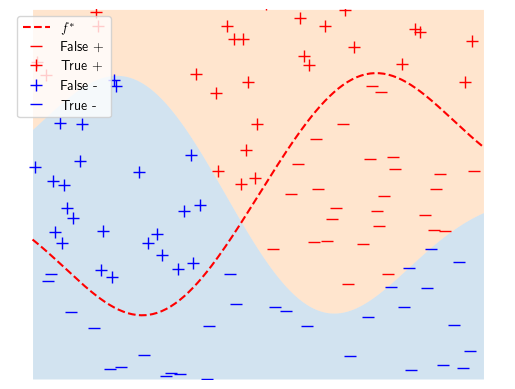

In [8]:
# Obtain data.
x_train=pixels
x_1_n_f, x_2_n_f, x_1_p_t, x_2_p_t, x_1_n_t, x_2_n_t, x_1_p_f, x_2_p_f = npjudg(x_train, f_star(x_train), f_0(x_train))

#x = np.linspace(-1, 1, 50)
y = f_star(pixels)
y_0 = f_0(pixels)

plt.figure()
#plt.plot(x,y_0,color='lime',label='Boundary'+r'$^0$')
plt.plot(pixels,y,color='red',linestyle='dashed', label=r'$f^*$')

#plt.plot(x_1_p, x_2_p, '+', color='red',label='Ture + example ')
#plt.plot(x_1_n, x_2_n, 'x', color='b',label='Ture - example')
plt.plot(x_1_p_f, x_2_p_f, '_', color='red',label='False +',markersize=8)
plt.plot(x_1_p_t, x_2_p_t, '+', color='red',label='True +',markersize=8)

plt.plot(x_1_n_f, x_2_n_f, '+', color='b',label='False -',markersize=8)
plt.plot(x_1_n_t, x_2_n_t, '_', color='b',label='True -',markersize=8)


plt.fill_between(pixels, y_0, 1.5, color='C1', alpha=0.2, linewidth=0.0)
plt.fill_between(pixels, y_0, -1.5, color='C0', alpha=0.2, linewidth=0.0)

plt.ylim(-1.5, 1.5)

plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.legend(loc='best', prop={'size': 10})
plt.axis('off')

#plt.title('Comparison of '+r'$\theta^*$'+' and '+r'$\theta^0$'+' models')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

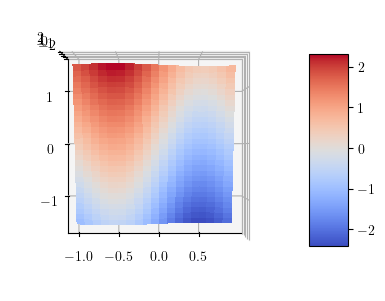

In [9]:
# Function for figure
def f_star_plt(X,X2):
    Z = X2-f_star(X)
    return Z

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig = plt.figure(figsize=(10,5))

# Make data.
X = np.arange(-1, 1, 0.1)
Y = np.arange(-1.5, 1.5, 0.1)
X, Y = np.meshgrid(X, Y)

# Plot the surface 0
Z = np.array(f_star_plt(X, Y))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf0 = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.view_init(90,270)
fig.colorbar(surf0, shrink=0.5, aspect=5) # Add a color bar which maps values to colors.
"""
# Plot the surface 8
Z = np.array(f_0_plt(X, Y))
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf8 = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(75,45)
fig.colorbar(surf8, shrink=0.5, aspect=5)"""

plt.show()

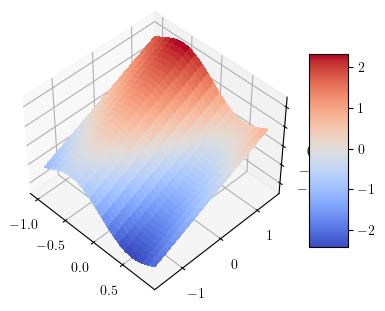

In [10]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig = plt.figure(figsize=(10,5))

# Make data.
X = np.arange(-1, 1, 0.1)
Y = np.arange(-1.5, 1.5, 0.1)
X, Y = np.meshgrid(X, Y)

# Plot the surface 0
Z = np.array(f_star_plt(X, Y))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf0 = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.view_init(45,315)
fig.colorbar(surf0, shrink=0.5, aspect=5) # Add a color bar which maps values to colors.
"""
# Plot the surface 8
Z = np.array(f_0_plt(X, Y))
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf8 = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(75,45)
fig.colorbar(surf8, shrink=0.5, aspect=5)"""

plt.show()

### Training

In [11]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    return np.exp(-(((x_1 - x_2) / 0.5) ** 2))

In [12]:
def greedy_B(y_t, y_s, batch):
    '''
    it can be threshold if batch <=1
    y_t, y_s are [x1,x2,x3]
    output: index of top k in x_list corresponded to y_t
    '''
    dif = torch.abs(y_t-y_s)
    
    #one point or many point
    if batch > 1 or  batch == 1:
        _, ind = torch.topk(dif,batch)
    elif (batch>0 and batch<1) or  batch == -1:
        _, ind = torch.topk(dif,int(np.abs(batch)*len(y_s)))
    else:
        print("Invalid batch!")
    
    return ind

In [13]:
#batch gradient
def gradient(x, y, x_list, y_t, K): #add a argument "type" for specified loss
    '''
    input x: [x1, x2, ...], need np.newaxis -> [[x1],[x2]]
    
    #1D linear approximate
    cen = x_list[0:-1]+x_list[1:]/2
    #input data x should be [x1,x2,...,xn]
    dif=abs(x[:,np.newaxis]-cen)
    #lower ind
    ind = dif.argmin(axis=1)[:,np.newaxis]
    #ind
    ind = np.hstack((ind,ind+1))
    
    a, b = x_list[ind][:,0], x_list[ind][:,1]
    
    coe=(x-b)/(a-b)
    
    y_a=y_t[ind[:,0]]
    y_b=y_t[ind[:,1]]
    #print(coe)
    f_x=coe*y_a+(1-coe)*y_b#f_t(x) is a vector related to input x
    '''
    _, ind = torch.topk(torch.abs(x_list-x),1, largest=False)
    f_x=y_t[ind]#same long as x
    
    
    #hinge loss
    '''
    gradient = np.zeros((len(f_x), len(x_list))) #gradient should be a matrix
    print(gradient[True])
    print(y,f_x)
    jud = 1-y*f_x > 0
    print(gradient[jud])
    if sum(jud) > 0:
        gradient[jud] = (-torch.unsqueeze(y, 1)*K(torch.unsqueeze((x), 1), x_list))[jud] #K stores the movement of every point in x_list
    '''
    if 1-y*f_x > 0:
        gradient = -torch.unsqueeze((y), 1)*K(x, x_list)
    else: 
        gradient = np.zeros((len(f_x), len(x_list)))
    #aggregate
    #print(gradient[10],gradient[25],gradient[40])
    gradient = gradient.sum(axis=0)
    #print(gradient)
    #print(gradient)
    return gradient

Hinge loss $L[f]=\max(0,1-y_i*f(x_i))$  $DL[f]=0\, or -y_i*K(x_i, \cdot)$

In [ ]:
#clear_print
'''
Only change points corresponding to example provided
'''
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
selexp_t = []
y_0 = f_0(pixels)
f_t.append(y_0)
y_star = f_star(pixels)
loss_0 = np.linalg.norm(y_0-y_star)/len(y_star)
loss_t.append(loss_0)
tm_t.append(0)
#selexp_t.append(float('nan')) no need to add nan, the first selected is based on f^0

iter_count = 0
step = 0.05*num_iterations
while iter_count < num_iterations:
    if loss_t[-1]<0.001:
        break
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)
    
    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    
    sel_idx = greedy_B(f_t[-1], y_star, 1)
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''
    
    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    example = pixels[sel_idx]#torch.tensor([14,14])
    #print(example)
    label = f_star(example)
    selexp_t.append(float(example))
    
    '''
    torch.Size([784]) - torch.Size([784])
    '''
    f_t.append((f_t[-1] -eta*gradient(example, label, pixels, f_t[-1], rbf_kernel)))
    loss_t.append(np.linalg.norm(f_t[-1]-y_star)/len(y_star))
    tm_t.append(time.time() - training_start_time)
    iter_count += 1
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

In [15]:
#data_path = os.path.join(script_path,'data','matching','cheetah.jpg')
save_path = os.path.join(script_path,'out','toy')

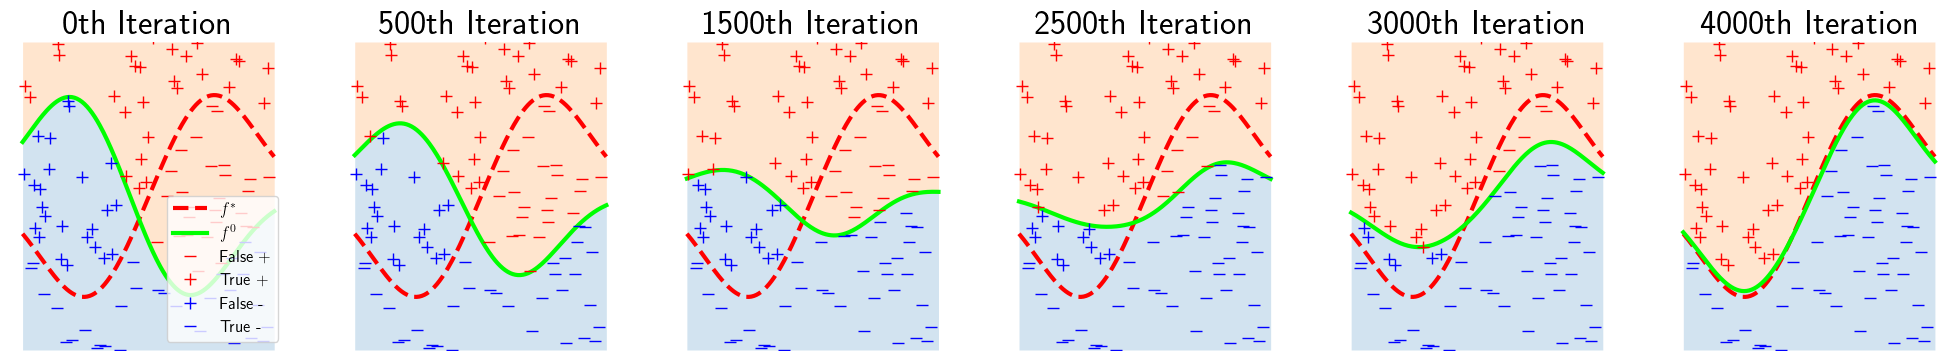

In [17]:
np.random.seed(seed)
bound = 1
flt = 0.1

#plt.plot(pixels,y_0,color='lime',label=r'$f^0$', linewidth=3)
ite_list = [0, 500, 1500, 2500, 3000, 4000]

sf = plt.figure(figsize=(25,4))

ind = 0

for i in ite_list:
    ind += 1
    
    plt.subplot(1,len(ite_list),ind)
    plt.plot(pixels,y,color='red',label=r'$f^*$', linestyle='dashed', linewidth=3)
    plt.plot(pixels,f_t[i],color='lime',label=r'$f^{{{}}}$'.format(i), linestyle='-', linewidth=3)
    
    plt.fill_between(pixels, f_t[i], 1.5, color='C1', alpha=0.2, linewidth=0.0)
    plt.fill_between(pixels, f_t[i], -1.5, color='C0', alpha=0.2, linewidth=0.0)
    
    x_1_n_f, x_2_n_f, x_1_p_t, x_2_p_t, x_1_n_t, x_2_n_t, x_1_p_f, x_2_p_f = npjudg(x_train, f_star(x_train), f_t[i])
    
    plt.plot(x_1_p_f, x_2_p_f, '_', color='red',label='False +',markersize=8)
    plt.plot(x_1_p_t, x_2_p_t, '+', color='red',label='True +',markersize=8)

    plt.plot(x_1_n_f, x_2_n_f, '+', color='b',label='False -',markersize=8)
    plt.plot(x_1_n_t, x_2_n_t, '_', color='b',label='True -',markersize=8)
    
    #plt.gca().set_aspect('equal', adjustable='box')
    
    plt.ylim(-1.5, 1.5)
    '''
    if ind < len(ite_list):
        plt.axvline(x=selexp_t[i],ls="-",c="b", linewidth=1)#, ymin=0.05, ymax=0.95
        plt.text(selexp_t[i],0.25,r'$x=${:.1f}'.format(selexp_t[i]),fontdict={'size':'10','color':'b'},horizontalalignment='left',verticalalignment='center')
    '''
    plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
    if ind==1: plt.legend(loc='lower right', prop={'size': 12})
    plt.title('{}th Iteration'.format(i),size = 25)
    plt.axis('off')
    if ind >1: 
        plt.yticks([]) 
    #plt.xlabel('x')
    #plt.ylabel('y')
plt.show()

sf.savefig(save_path+'/classification.pdf',bbox_inches='tight')